<a href="https://colab.research.google.com/github/kaushikpatriot/ML-Work/blob/main/Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def warn(*args, **kwargs):
  pass

warnings.warn = warn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Common Libraries

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class Mean_Encoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.initiated = True
    #return self

  def fit(self, X, y):
    self.mean_encode = {}
    #print(X.head())
    train_mean = X.copy()
    train_mean['Offer Accepted'] = y
    for feature in train_mean.columns:
      self.mean_encode[feature] = train_mean.groupby(feature)['Offer Accepted'].mean().round(3)
    #print(self.mean_encode,'\n')
    return self

  def transform(self, X):
    X_new = X.copy()
    for feature in X.columns:
      X_new.loc[:, feature] = X[feature].map(self.mean_encode[feature])
    return X_new

In [ ]:
class train_model():
  def __init__(self, test_size = 0.3):
    train_path = '/content/drive/MyDrive/Colab Notebooks/MLP-Code/Project/train_data.csv'
    self.train_df = pd.read_csv(train_path)
    test_path = '/content/drive/MyDrive/Colab Notebooks/MLP-Code/Project/test_data.csv'
    self.test_df = pd.read_csv(test_path)
    self.train_df.drop(['car','travelled_more_than_5mins_for_offer'], axis = 1, inplace=True)
    self.test_df.drop(['car','travelled_more_than_5mins_for_offer'], axis = 1, inplace=True)
    self.random_state = 43
    self.test_size = test_size

  def custom_encoding(self):
    #Dictionary for encoding
    self.custom_encoding_dict = {'offer expiration': {'2days':48, '10hours':10},
                    'income_range': {'₹100000 or More': 100000, '₹87500 - ₹99999': 87500, '₹37500 - ₹49999': 37500, 'Less than ₹12500': 5000, '₹50000 - ₹62499': 50000,
                                      '₹12500 - ₹24999': 12500, '₹75000 - ₹87499': 75000, '₹25000 - ₹37499': 25000, '₹62500 - ₹74999': 62500},
                    'no_visited_Cold drinks': {'4~8':3,'less1':1, 'never':0, '1~3':2, 'gt8': 4},
                    'Restaur_spend_less_than20': {'less1':1, '4~8':3, '1~3':2, 'gt8':4, 'never': 0},
                    'age': {'36':36, '50plus':50, '26':26, '46':46, '21':21, 'below21':18, '41':41, '31':31},
                    'no_visited_bars': {'less1':1, 'never':0, '1~3':2, '4~8':3, 'gt8':4},
                    'Qualification': {'Bachelors degree': 3,  'Some college - no degree': 2, 'Graduate degree (Masters or Doctorate)': 5, 'Associates degree': 4,
                                      'High School Graduate': 1, 'Some High School': 0 },
                    'no_Take-aways': {'less1':1, 'never':0, '1~3':2, '4~8':3, 'gt8':4},
                    'Restaur_spend_greater_than20': {'less1':1, 'never':0, '1~3':2, '4~8':3, 'gt8':4},
                    }

    self.label_encoding_list = ['Marital Status', 'gender' , 'Customer type', 'Job/Job Industry', 'Climate' ,'drop location','restaurant type']
    self.no_encoding_list = ['travelled_more_than_15mins_for_offer', 'Prefer western over chinese','travelled_more_than_25mins_for_offer', 'restuarant_same_direction_house',
                    'Cooks regularly', 'is foodie','restuarant_opposite_direction_house', 'has Children','visit restaurant with rating (avg)', 'temperature', 'Travel Time', 'Prefer home food' ]
    self.numeric_list = ['income_range', 'age', 'offer expiration']
    self.one_hot_encoding_list = ['Marital Status', 'gender' , 'Customer type', 'Job/Job Industry', 'Climate' ,'drop location','restaurant type', 'Qualification']

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    #Custom encoding certain fields
    self.train_enc = self.train_df.copy()
    self.test_enc = self.test_df.copy()
    for feature in self.custom_encoding_dict.keys():
        self.train_enc[feature] = self.train_df[feature].map(self.custom_encoding_dict[feature])
        self.test_enc[feature] = self.test_df[feature].map(self.custom_encoding_dict[feature])

    #Label encoding certain fields
    for feature in self.label_encoding_list:
      self.train_enc[feature] = le.fit_transform(self.train_enc.loc[:, feature])
      self.test_enc[feature] = le.transform(self.test_enc.loc[:, feature])

    self.train_enc['Offer Accepted'] = le.fit_transform(self.train_enc.loc[:, 'Offer Accepted'])

    #Splitting features and Labels
    self.train_X = self.train_enc.iloc[:, :-1]
    self.train_y = self.train_enc.iloc[:, -1]
    self.test_X = self.test_enc

  def knn_impute(self):
    from sklearn.impute import KNNImputer
    knn = KNNImputer(n_neighbors = 5)
    self.train_imp = knn.fit_transform(self.train_X)
    self.train_imp = pd.DataFrame(self.train_imp, columns = self.train_X.columns)
    self.test_imp = knn.transform(self.test_enc)
    self.test_imp = pd.DataFrame(self.test_imp, columns = self.test_enc.columns)
    missing_cols = ['no_visited_Cold drinks', 'Restaur_spend_less_than20', 'no_visited_bars', 'no_Take-aways', 'Restaur_spend_greater_than20']
    for i in missing_cols:
      self.train_imp[i] = self.train_imp[i].round(0)
      self.test_imp[i] = self.test_imp[i].round(0)

  def simple_impute(self):
    from sklearn.impute import SimpleImputer
    ss = SimpleImputer(strategy = 'most_frequent')
    self.train_imp = ss.fit_transform(self.train_X)
    self.test_imp = ss.transform(self.test_X)
    self.test_imp = pd.DataFrame(self.test_imp, columns = self.test_X.columns)

  def test_split(self):
    from sklearn.model_selection import train_test_split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.train_imp, self.train_y, test_size = self.test_size, random_state = self.random_state)
    self.X_train = pd.DataFrame(self.X_train, columns = self.train_X.columns)
    self.X_test = pd.DataFrame(self.X_test, columns = self.train_X.columns)

  def run_model(self, model, enc_type, model_name, with_SMOTE = False, gridSearch = False, params = None):
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedKFold
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state = self.random_state, k_neighbors = 5)
    if (enc_type == 'all_mean'):
      ct_trgt = ColumnTransformer(transformers = [('Mean Encoding', Mean_Encoder(), slice(0,27))], remainder = Mean_Encoder())
    elif (enc_type == 'trgt_mean'):
      ct_trgt = ColumnTransformer(transformers = [('StandardScaler', StandardScaler(), self.numeric_list)], remainder = Mean_Encoder())
    elif (enc_type == 'combo'):
      ct_trgt = ColumnTransformer(transformers = [('StandardScaler', StandardScaler(), self.numeric_list), ('OneHot', OneHotEncoder(), self.one_hot_encoding_list)
                                                  ], remainder = Mean_Encoder())
    elif (enc_type == 'ord_mean'):
      ct_trgt = ColumnTransformer(transformers = [('StandardScaler', StandardScaler(), self.numeric_list), ('MeanEncoding', Mean_Encoder(), self.one_hot_encoding_list)
                                                  ], remainder = 'passthrough')
    else:
      ct_trgt = ColumnTransformer(transformers = [('passthrough', 'passthrough', slice(0,27))])

    if (with_SMOTE):
      self.X_train_new, self.y_train_new = sm.fit_resample(self.X_train, self.y_train)
    else:
      self.X_train_new, self.y_train_new = self.X_train, self.y_train

    self.pipe = Pipeline([('ct', ct_trgt),
                      ('estm', model)])

    if (gridSearch):
      rkf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = self.random_state)
      self.est = GridSearchCV(estimator = self.pipe, param_grid = params, cv = rkf, scoring = 'f1', error_score = 'raise', return_train_score = True)
      self.est.fit(self.X_train_new, self.y_train_new)
      self.metrics_display(self.est)
      print(self.est.best_params_)
      print(self.est.best_score_)
      print(self.est.cv_results_)
    else:
      self.pipe.set_params(**params)
      self.pipe.fit(self.X_train_new, self.y_train_new)
      self.metrics_display(self.pipe)
      label_pred = self.pipe.predict(self.test_imp)
      self.gen_submission_file(label_pred, model_name)

  def metrics_display(self, estim):
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
    y_pred = estim.predict(self.X_test)
    #----------------------------------------------------------------------------------
    print(f'Accuracy on Training: {estim.score(self.X_train_new, self.y_train_new)}')
    print()
    print(f'Accuracy on Test: {estim.score(self.X_test, self.y_test)}')
    print()
    print('---------------------------------------------------------------')
    print(classification_report(self.y_test, y_pred))
    cm = confusion_matrix(self.y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    RocCurveDisplay.from_estimator(estim, self.X_test, self.y_test, pos_label = 1)
    PrecisionRecallDisplay.from_estimator(estim, self.X_test, self.y_test, pos_label = 1)
    plt.show()

  def gen_submission_file(self, label_pred , name):
    f = open(f'submissions_{name}.csv', "w")
    f.write('id' + ',' + 'Offer Accepted\n')
    for i in range(len(label_pred)):
      if (label_pred[i] == 0):
        f.write(str(i) + ',' + 'No\n')
      else:
        f.write(str(i) + ',' + 'Yes\n')
    f.close()


Accuracy on Training: 0.5160569105691057

Accuracy on Test: 0.48707592891760904

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.45      0.73      0.56      1640
           1       0.58      0.30      0.39      2074

    accuracy                           0.49      3714
   macro avg       0.51      0.51      0.47      3714
weighted avg       0.52      0.49      0.46      3714



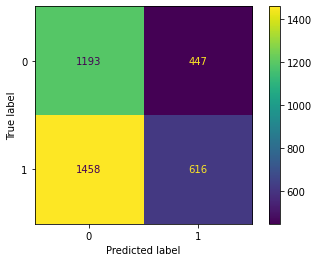

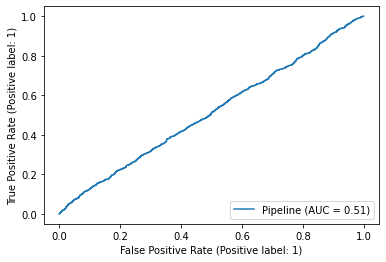

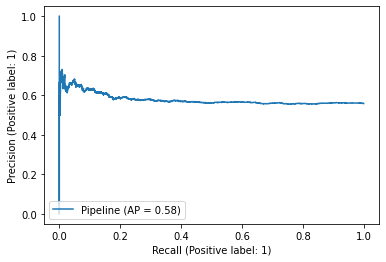

In [ ]:
from sklearn.linear_model import LogisticRegression
dat = train_model()
dat.custom_encoding()
dat.knn_impute()
dat.test_split()
gs_params = {'estm__C': [1, 2, 5], 'estm__penalty': ['l2'], 'estm__solver':['saga'], 'estm__max_iter': [100,200], 'estm__random_state': [42] }
#mdl_params = {'estm__C':2, 'estm__class_weight':'balanced', 'estm__l1_ratio': 0, 'estm__max_iter': 200, 'estm__penalty': 'l2', 'estm__random_state': 42}
mdl_params = {'estm__C': 1, 'estm__max_iter': 100, 'estm__penalty': 'l1', 'estm__random_state': 42, 'estm__solver': 'saga'}
lr = LogisticRegression()
dat.run_model(model = lr,enc_type = 'one_hot', model_name = 'log_reg', with_SMOTE = True, gridSearch = False, params = mdl_params)

Accuracy on Training: 0.9973577235772357

Accuracy on Test: 0.6254711900915455

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.40      0.48      1640
           1       0.63      0.81      0.71      2074

    accuracy                           0.63      3714
   macro avg       0.62      0.60      0.59      3714
weighted avg       0.62      0.63      0.61      3714



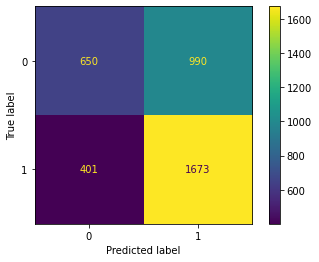

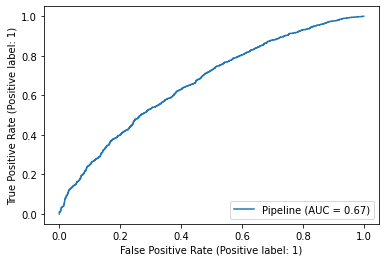

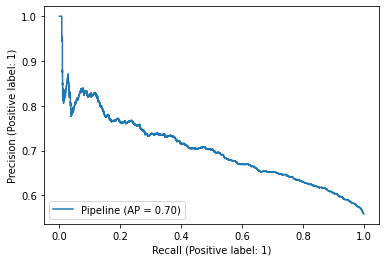

In [ ]:
from sklearn.ensemble import RandomForestClassifier
dat = train_model()
dat.custom_encoding()
dat.knn_impute()
dat.test_split()
gs_params = {'estm__criterion': ['gini', 'entropy'], 'estm__n_estimators':[100, 200, 300], 'estm__max_depth': [None, 10, 20], 'estm__min_samples_split': [5,10,15],'estm__random_state': [42], 'estm__min_impurity_decrease': [0.0001, 0.001, 0.01]}
mdl_params = {'estm__criterion': 'entropy', 'estm__max_depth': None, 'estm__min_impurity_decrease': 0.0001, 'estm__min_samples_split': 5, 'estm__n_estimators': 200, 'estm__random_state': 42}
#{'estm__max_depth':None, 'estm__min_samples_split': 10, 'estm__n_estimators': 100, 'estm__random_state': 42}
rf = RandomForestClassifier()
dat.run_model(model = rf,enc_type = 'ord_mean', model_name = 'rdm_frst', with_SMOTE = True, gridSearch = False, params = mdl_params)

Accuracy on Training: 0.6485772357723577

Accuracy on Test: 0.6007000538502961

---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.39      0.46      1640
           1       0.61      0.77      0.68      2074

    accuracy                           0.60      3714
   macro avg       0.59      0.58      0.57      3714
weighted avg       0.59      0.60      0.58      3714



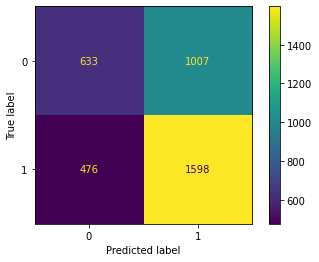

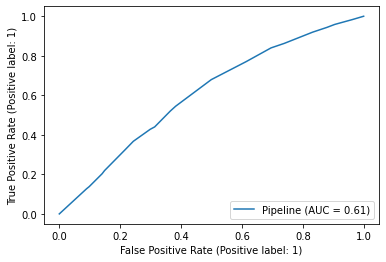

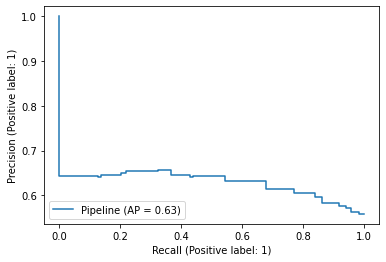

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dat = train_model()
dat.custom_encoding()
dat.simple_impute()
dat.test_split()
gs_params = {'estm__criterion': ['gini', 'entropy'], 'estm__n_estimators':[100, 200, 300], 'estm__max_depth': [None, 10, 20], 'estm__min_samples_split': [5,10,15],'estm__random_state': [42], 'estm__min_impurity_decrease': [0.0001, 0.001, 0.01]}
mdl_params = {'estm__criterion': 'entropy', 'estm__max_depth': 10, 'estm__min_impurity_decrease': 0.001, 'estm__min_samples_split': 5, 'estm__random_state': 42}
#{'estm__max_depth':None, 'estm__min_samples_split': 10, 'estm__n_estimators': 100, 'estm__random_state': 42}
rf = DecisionTreeClassifier()
dat.run_model(model = rf,enc_type = 'no_enc', model_name = 'dtree', with_SMOTE = True, gridSearch = False, params = mdl_params)


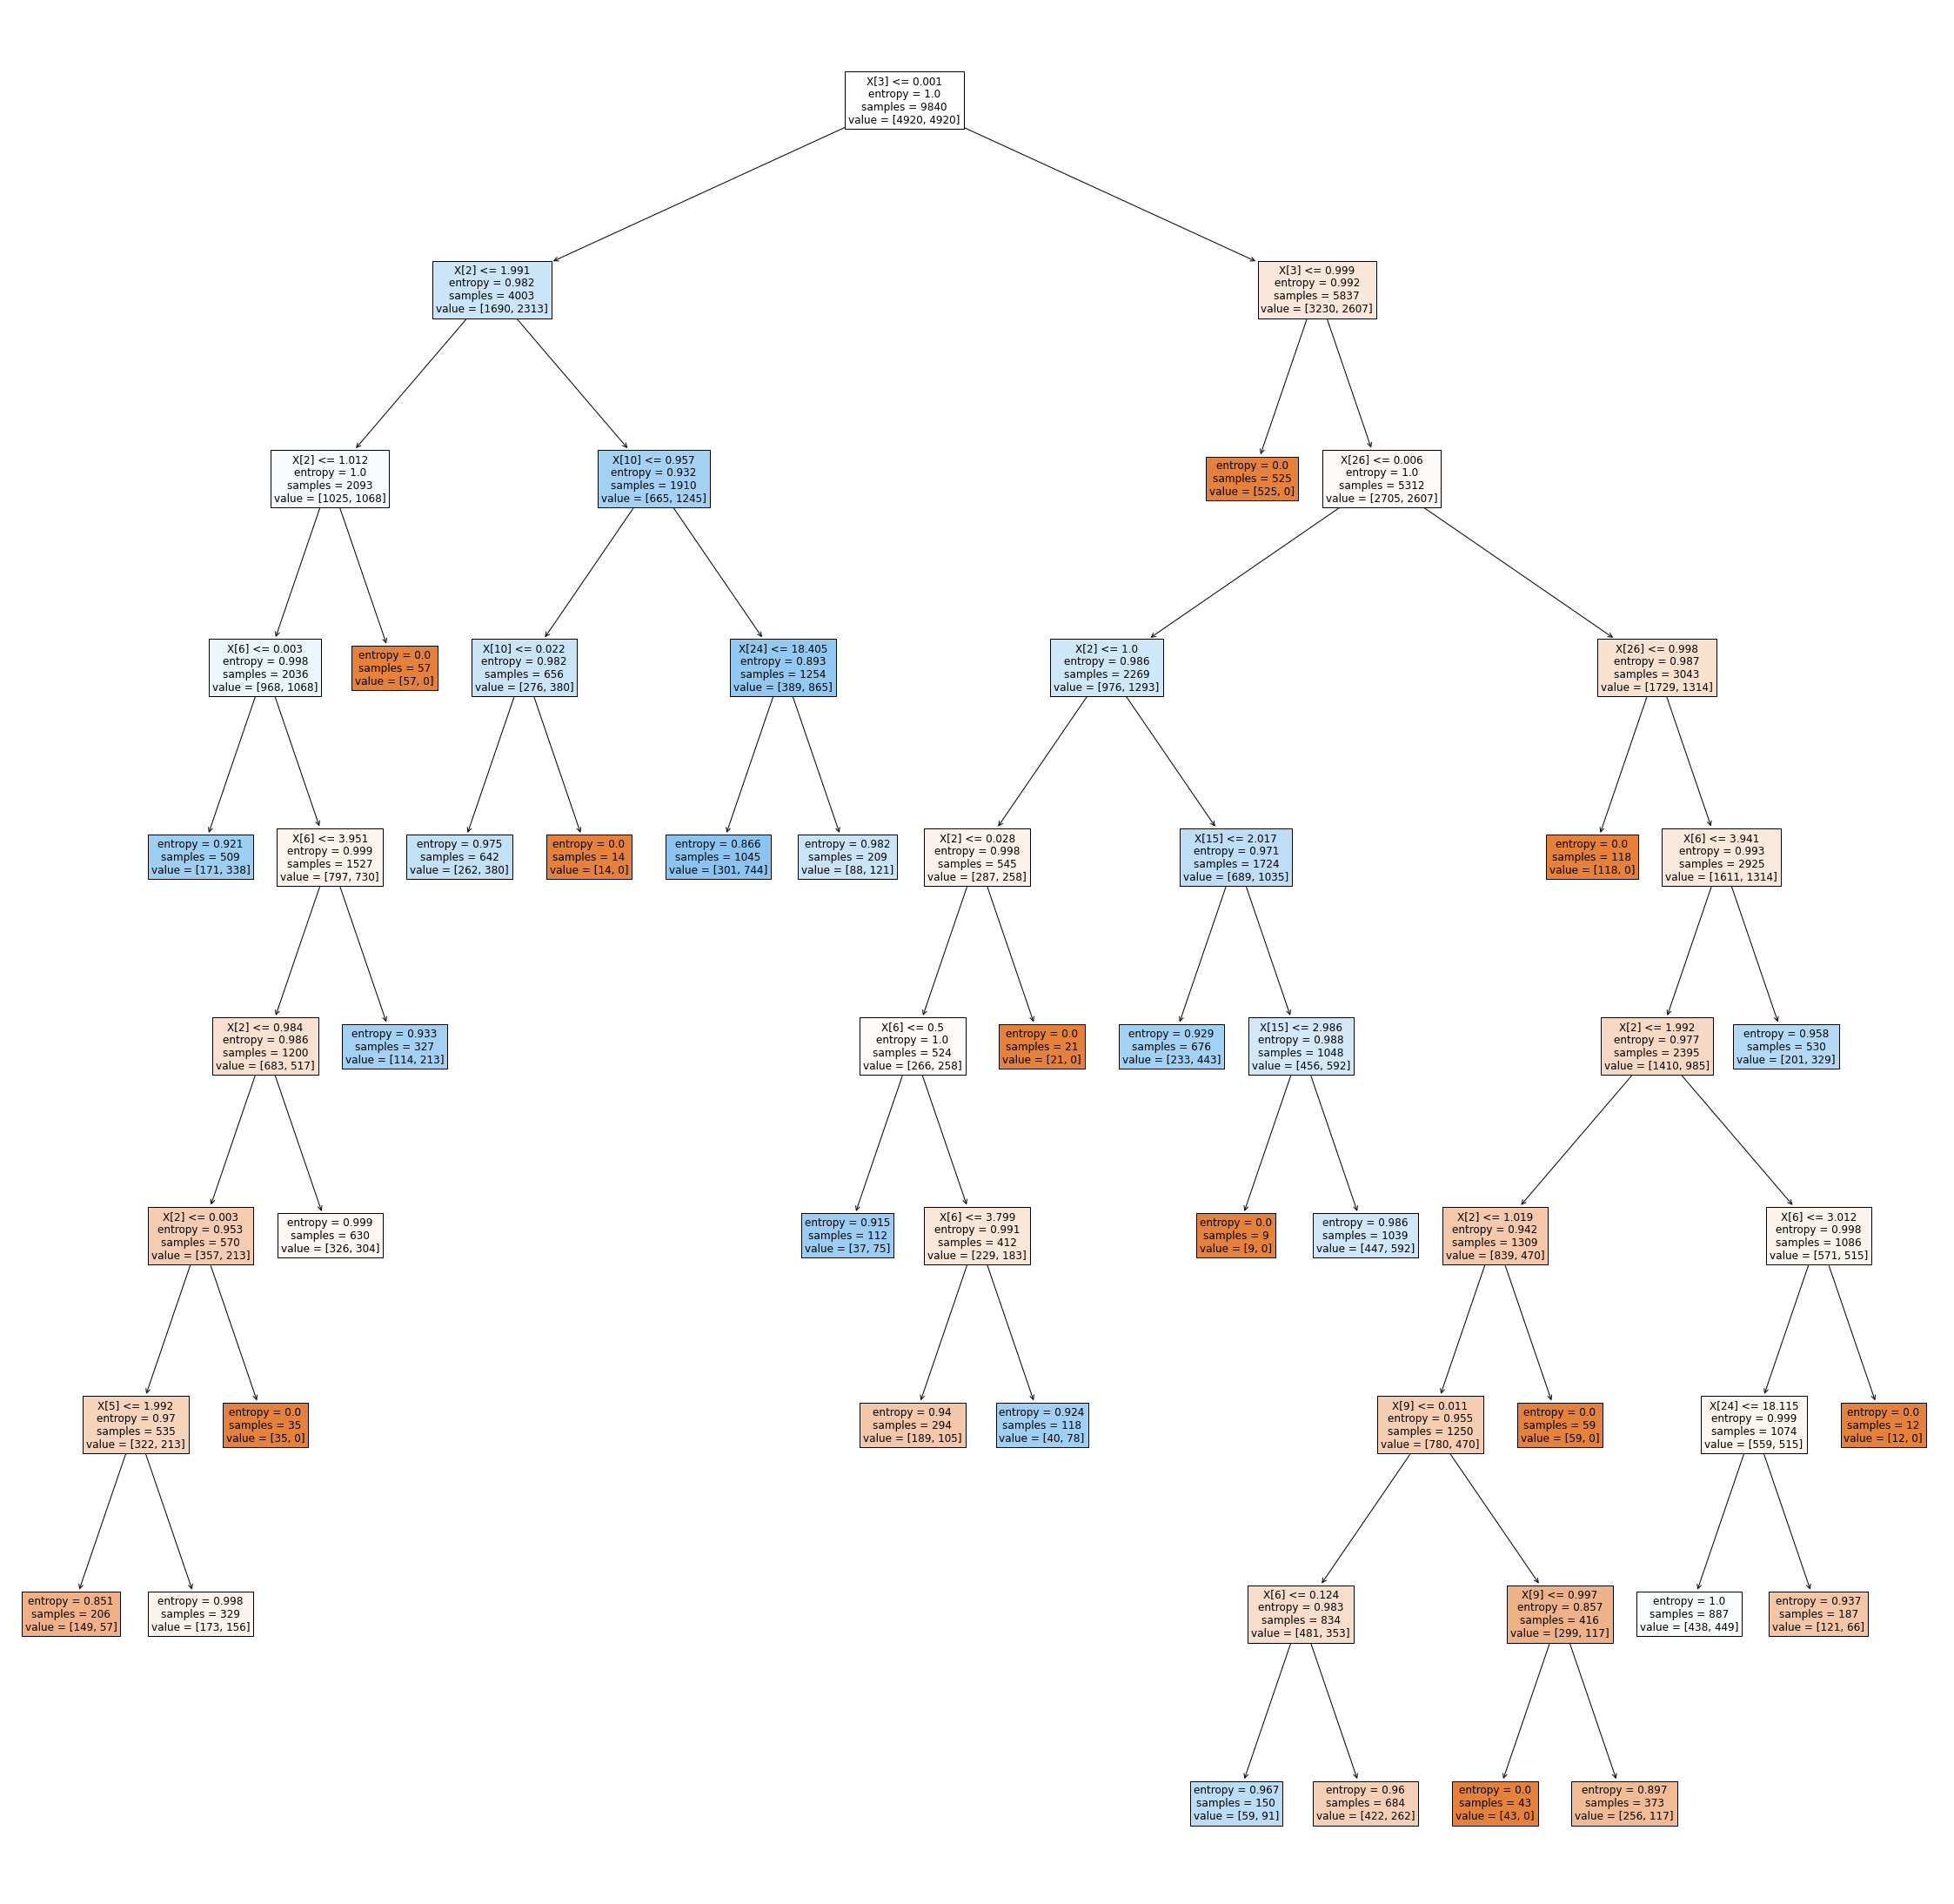

In [ ]:
from sklearn import tree
plt.figure(figsize = (40,40))
tree.plot_tree(dat.pipe[-1], fontsize = 12, filled = True)
plt.show()